In [60]:
import tensorflow
from tensorflow.keras import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation,Dense
from tensorflow.keras.layers import AveragePooling2D,concatenate,GlobalAveragePooling2D
from tensorflow.keras import Input

#### Inception naive version

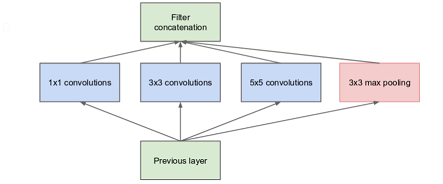

In [61]:
#inception naive version
# f1;f2;f3 = Filters at specific Block (1X1;5X5;3X3)

def inception_module(x, f1, f2, f3):
    # 1x1 conv
    conv1 =  Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(x)
    
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(x)
    
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    
    # concatenate filters
    out = keras.layers.merge.concatenate([conv1, conv3, conv5, pool])
    
    return out

### InceptionV3

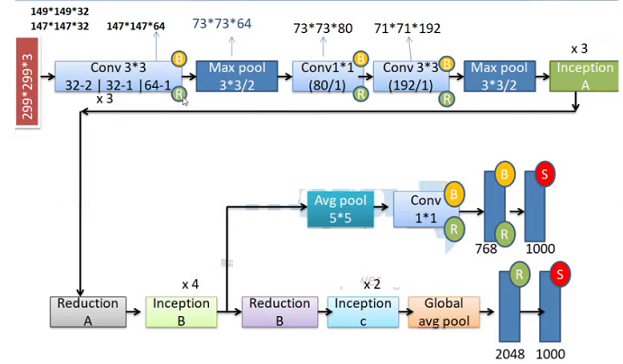

In [62]:
'''

Inception V3

Layer Structure of InceptionV3

- Every Conv Layer we are using Bacth Normalization and Relu Activation Layer

- Input for inception V3 is 299X299X3


Block_A
    - 1st Conv Layer 
        - 32 Filter with size of (3*3) and Stride of 2

    - 2nd Conv Layer 
        - 32 Filter with size of (3*3) and Stride of 1

    - 3rd Conv Layer 
        - 64 Filter with size of (3*3) and Stride of 1

    - Max pooling Layer: Window Size : 3X3 and stride is 2
    
    - 4th Conv Layer
        - 80 Filter with size of (1*1) and stride is 1
    
    - 5th conv layer
        - 192 Filter with size of (3*3) and stride is 1
    
    - Max pooling Layer: Window Size : 3X3 and stride is 2
    
Inception Block_A: Inception Block A (inc_block_a)
    - Inception Will start here
    - 3 Incpetion repeaded
    
Reduction A:

Inception Block_B :

Reduction B:

Inception Block_B :

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-62-5b9ef2cd461b>, line 42)

In [72]:
# Input for Inception moduel is 299*229*3
img_input = Input(shape=(299, 299, 3))

classes=3 # Three Classes
channel_axis=3

In [64]:
# Convolution Layer along with Batch Normalization and Relu activation Function
# filters : Number of Filters
# num_row,num_col : Size of the filters
# axis=3 : Channels

def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    return x

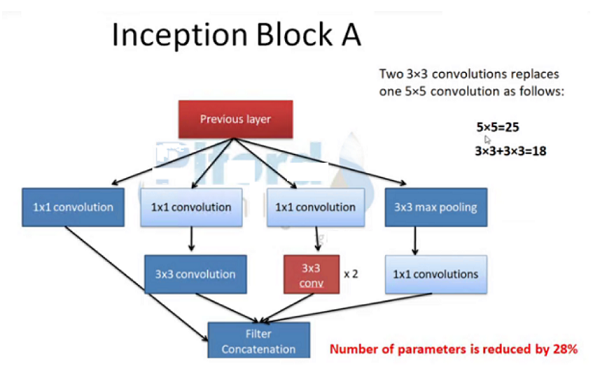

In [65]:
def inc_block_a(x):    
    branch1x1 = conv2d_bn(x, 64, 1, 1)  # 64 filters of 1*1

    branch5x5 = conv2d_bn(x, 48, 1, 1)  #48 filters of 1*1
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x

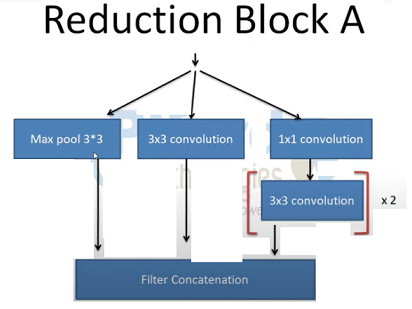

In [66]:
def reduction_block_a(x):  
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

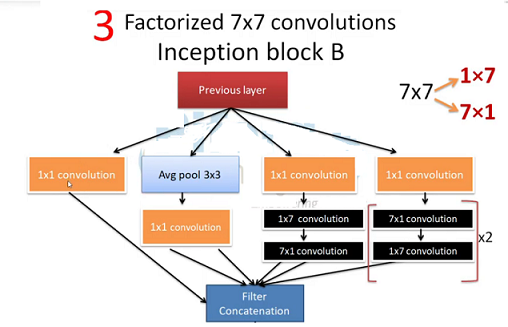

In [67]:
# 17 x 17 x 768
def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x

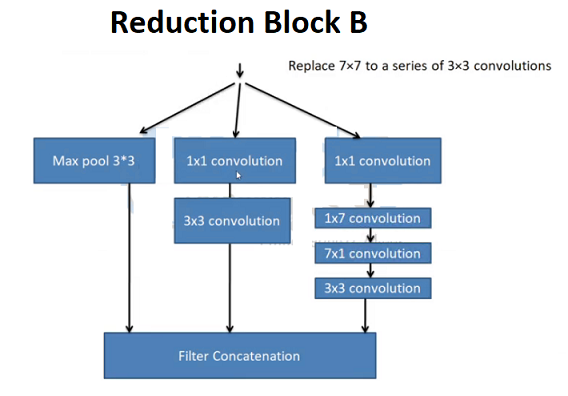

In [68]:
# mixed 8: 8 x 8 x 1280
def reduction_block_b(x): 
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn( branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x

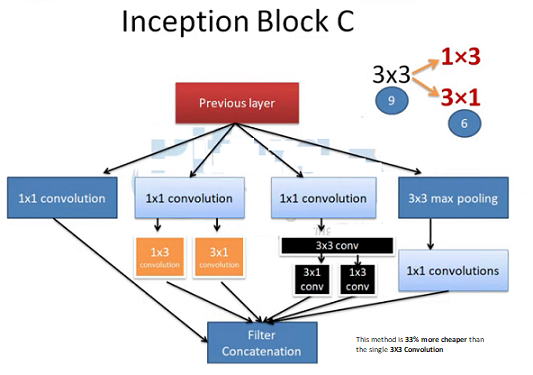

In [69]:
def inc_block_c(x):
    branch1x1 = conv2d_bn(x, 320, 1, 1)

    branch3x3 = conv2d_bn(x, 384, 1, 1)
    branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
    branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
    branch3x3 = concatenate([branch3x3_1, branch3x3_2],axis=channel_axis)

    branch3x3dbl = conv2d_bn(x, 448, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
    branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
    branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
    branch3x3dbl = concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate( [branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

# Building a model layer by layer

In [73]:
# input image size: 299 x 299 x 3
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # 149 x 149 x 32
x = conv2d_bn(x, 32, 3, 3, padding='valid')  # 147 x 147 x 32
x = conv2d_bn(x, 64, 3, 3) # 147 x 147 x 64
x = MaxPooling2D((3, 3), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 80, 1, 1, padding='valid') # 73 x 73 x 80
x = conv2d_bn(x, 192, 3, 3, padding='valid')  # 71 x 71 x 192
x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 35 x 35 x 192

# Inception will start here : 
# Inception A Block : 3
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256

# Reduction Block A
x=reduction_block_a(x) #17, 17, 736

# Inception B Block : 4
x = inc_block_b(x)
x = inc_block_b(x)
x = inc_block_b(x)
x = inc_block_b(x)

x=reduction_block_b(x) #shape=(None, 8, 8, 1280)

x=inc_block_c(x) # shape=(None, 8, 8, 2048) 
x=inc_block_c(x) # shape=(None, 8, 8, 2048) 

x = GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)

x = Dense(classes, activation='softmax', name='predictions')(x) #shape=(None, 3) 

# Create model.
inputs = img_input
model =  Model(inputs, x, name='inception_v3')
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_857 (Conv2D)             (None, 149, 149, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_857 (BatchN (None, 149, 149, 32) 96          conv2d_857[0][0]                 
__________________________________________________________________________________________________
activation_857 (Activation)     (None, 149, 149, 32) 0           batch_normalization_857[0][0]    
_______________________________________________________________________________________

In [83]:
# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='inception_model_3.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
